In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [309]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
from librosa import display
warnings.filterwarnings('ignore')

In [310]:
pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list

def pitch_trans(seq):
    pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']
    return pitch_list[seq]

def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]


## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [311]:
## Analysis chord and pitch4
def n_gram(key_list, ngram):
    ngram_key = []
    flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(flattened)-3)):
        ngram_key.append(flattened[i : ngram +i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

def n_gram2(key_list, ngram):
    ngram_key = []
#     flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(key_list)-3)):
        ngram_key.append(key_list[i : ngram+i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

## Get Chord (4 beats)

In [312]:
## get all file name
sleeping_music = sorted(get_dirs('./music/sleeping'))

print(len(sleeping_music))

75


In [314]:
sleeping_key = []; pitch = []
def job(num1, num2):
#     for idx in range(len(sleeping_music)):
    for idx in range(num1, num2):
        temp2 = []; temp3 = []
        for d in range(300):
            try:
                y1, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx],offset=4*d,duration = 4, res_type = "kaiser_fast")
                ## onset detection
#                 o_env = librosa.onset.onset_strength(y1, sr=sr)
#                 onset_frames = librosa.onset.onset_detect(y=y1, onset_envelope=o_env, sr=sr)
                o_env = librosa.onset.onset_strength(y1, sr=sr)
                onset_frames = librosa.util.peak_pick(o_env, 7, 7, 7, 7, 0.5, 5)
                ## pitch detection
                b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=512)

                temp =[]
                for i in range(len(onset_frames)): 
                    temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
                for i in range(len(temp)):
                    temp3.append(pitch_trans(temp[i]))    

                ## count CE
                CE = (count_CE(temp))
                temp2.append(get_key(CE, pitch_ary))
            except:
                pass
        sleeping_key.append(temp2)
        pitch.append(temp3)
        print("Finish", idx)

In [315]:
import threading
import time

## multi thread

threads = []; threads2 = []; threads3 = []; threads4 = []

threads.append(threading.Thread(target = job, args = (0,19))) 
for t in threads:
    t.start()
    
threads2.append(threading.Thread(target = job, args = (19,38))) 
for t2 in threads2:
    t2.start()
    
threads3.append(threading.Thread(target = job, args = (38,58))) 
for t2 in threads3:
    t2.start()
    
threads4.append(threading.Thread(target = job, args = (58,75))) 
for t2 in threads4:
    t2.start()
 

In [410]:
# ## to pickle file
# import pickle

# with open('key.pkl', 'wb') as f:
#     pickle.dump(sleeping_key, f)   
# with open('pitch.pkl', 'wb') as f:
#     pickle.dump(pitch, f)

# with open('key.pkl', 'rb') as f:
#     chord = pickle.load(f) 
# with open('pitch.pkl', 'rb') as f:
#     pitch = pickle.load(f)

In [409]:
len(pitch)

75

## Analysis - Chord

In [411]:
## pitch matching

perfect_five = [['C','G'],['G','D'],['D','A'],['A','E'],['E','B'],['B','F#'],['F#','C#'],['C#','G#'],
                ['G#','D#(E-)'],['D#(E-)','A#(B-)'],['A#(B-)','F'],['F','C']]

same_pitch2 = [['C','C','C'],['D','D','D'],['A','A','A'],['E','E','E'],['B','B','B'],['F#','F#','F#'],
              ['C#','C#','C#'],['G#','G#','G#'], ['D#(E-)','D#(E-)','D#(E-)'],
              ['A#(B-)','A#(B-)','A#(B-)'],['F','F','F'],['G','G','G']]

same_pitch = [['C','C'],['D','D'],['A','A'],['E','E'],['B','B'],['F#','F#'],['C#','C#'],
              ['G#','G#'], ['D#(E-)','D#(E-)'],['A#(B-)','A#(B-)'],['F','F'],['G','G']]

big_three = [['C','E'],['D','F#'],['E','G#'],['F','A'],['G','B'],['A','C#'],['B','D#'],
             ['C#','F'],['D#(E-)','G'],['F#','A#(B-)'],['G#','C'],['A#','D']]

small_three = [['C','D#'],['D','F'],['E','G'],['F','G#'],['G','A#'],['A','C'],['B','D'],
             ['C#','E'],['D#(E-)','F#'],['F#','A'],['G#','B'],['A#','C#']]

four_pitch = [['C','F'],['D','G'],['E','A'],['F','A#(B-)'],['G','C'],['A','D'],['B','E'],
             ['C#','F#'],['D#(E-)','G#'],['F#','B'],['G#','C#'],['A#','D#(E-)']]

whole_tone = [['C','D'],['D','E'],['E','F#'],['F','G'],['G','A'],['A','B'],['B','C#'],
             ['C#','D#(E-)'],['D#(E-)','F'],['F#','G#'],['G#','A#'],['A#','C'],
             ['D','C'],['E','D'],['F#','E'],['G','F'],['A','G'],['B','A'],['C#','B'],
             ['D#(E-)','C#'],['F','D#(E-)'],['G#','F#'],['A#','G#'],['C','A#']]

In [412]:
## if need flattern: flattened = [val for sublist in sleeping_key for val in sublist]
def count_pattern(data,a,b,c):  # a,b,c is scalar
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0; four = 0; whole = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0; four_= 0; whole_ = 0
    for i in range(int((len(data)-a)/a)):
        if data[i*a+b:i*a+c] in perfect_five:
            perfect = perfect+1
        elif data[i*a+b:i*a+c] in big_three:
            big3 = big3+1
        elif data[i*a+b:i*a+c] in small_three:
            small3 = small3+1
        elif data[i*a+b:i*a+c] in same_pitch:
            same = same+1
        elif data[i*a+b:i*a+c] in four_pitch:
            four = four+1
        elif data[i*a+b:i*a+c] in whole_tone:
            whole = whole+1
        else:
            non = non+1
        try:
            perfect_ = round(perfect/int(len(data)/a) *100,2)
            same_ = round(same/int(len(data)/a) *100,2)
            non_ = round(non/int(len(data)/a) *100,2)
            big3_ = round(big3/int(len(data)/a) *100,2)
            small3_ = round(small3/int(len(data)/a) *100,2)
            four_ = round(four/int(len(data)/a) *100,2)
            whole_ = round(whole/int(len(data)/a) *100,2)
        except:
            pass
    return perfect_, same_, non_ , big3_ , small3_ ,four_, whole_

### Chord progression in all dataset

In [413]:
flattened = [val for sublist in sleeping_key for val in sublist]
perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(flattened,1,0,2)
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')

Perfect 5: 17.13 %
Big three: 2.62 %
Small 4.79 %
Stable: 25.96 %
Four: 18.19 %
WholeTone: 18.23 %
Other 13.08 %


### Chord progression in each songs

In [414]:
for idx in range(len(sleeping_music)):
    perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(sleeping_key[idx],1,0,2)
    print(idx,sleeping_music[idx])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Four:",four_, '%')
    print("WholeTone:",whole_, '%')
    print("Other",non_, '%')
    print()

0 1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav
Perfect 5: 15.72 %
Big three: 3.34 %
Small 5.69 %
Stable: 21.74 %
Four: 17.73 %
WholeTone: 22.74 %
Other 12.71 %

1 3小时放鬆的音樂  背景音樂  純音樂 輕快 水音  禪修音樂  輕音樂  心靈音樂.wav
Perfect 5: 30.33 %
Big three: 0.0 %
Small 3.67 %
Stable: 27.67 %
Four: 19.67 %
WholeTone: 16.67 %
Other 1.67 %

2 Relaxing Piano Music Sleep Music Water Sounds Relaxing Music Meditation Music ★47🍀.wav
Perfect 5: 17.53 %
Big three: 4.38 %
Small 5.58 %
Stable: 15.14 %
Four: 21.51 %
WholeTone: 23.11 %
Other 12.35 %

3 [無廣告版] 讀書工作好心情！放鬆舒壓鋼琴和大自然音律 - 5 HOURS RELAX STUDYING MUSIC FOR CONCENTRATION.wav
Perfect 5: 9.25 %
Big three: 6.36 %
Small 8.67 %
Stable: 23.7 %
Four: 5.78 %
WholeTone: 19.08 %
Other 26.59 %

4 m1.wav
Perfect 5: 20.96 %
Big three: 1.8 %
Small 2.99 %
Stable: 29.94 %
Four: 18.56 %
WholeTone: 19.16 %
Other 5.99 %

5 m10.wav
Perfect 5: 20.47 %
Big three: 2.92 %
Small 6.43 %
Stable: 34.5 %
Four: 16.96 %
WholeTone: 9.36 %
Other 8.77 %

6 m11.wav
Perfect 5: 13.95 %
Big thr

### Chord progression between phrase - by songs

In [415]:
# flattened = [val for sublist in sleeping_key for val in sublist]
for i in range(len(sleeping_key)):
    perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(sleeping_key[i],4,3,5)
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Four:",four_, '%')
    print("WholeTone:",whole_, '%')
    print("Other",non_, '%')
    print()

Perfect 5: 10.81 %
Big three: 2.7 %
Small 2.7 %
Stable: 24.32 %
Four: 18.92 %
WholeTone: 27.03 %
Other 12.16 %

Perfect 5: 24.0 %
Big three: 0.0 %
Small 5.33 %
Stable: 26.67 %
Four: 20.0 %
WholeTone: 22.67 %
Other 0.0 %

Perfect 5: 16.13 %
Big three: 8.06 %
Small 4.84 %
Stable: 14.52 %
Four: 12.9 %
WholeTone: 25.81 %
Other 16.13 %

Perfect 5: 4.65 %
Big three: 4.65 %
Small 2.33 %
Stable: 27.91 %
Four: 6.98 %
WholeTone: 27.91 %
Other 23.26 %

Perfect 5: 21.95 %
Big three: 2.44 %
Small 2.44 %
Stable: 26.83 %
Four: 12.2 %
WholeTone: 19.51 %
Other 12.2 %

Perfect 5: 26.19 %
Big three: 2.38 %
Small 0.0 %
Stable: 28.57 %
Four: 23.81 %
WholeTone: 9.52 %
Other 7.14 %

Perfect 5: 13.7 %
Big three: 2.74 %
Small 9.59 %
Stable: 21.92 %
Four: 21.92 %
WholeTone: 20.55 %
Other 8.22 %

Perfect 5: 8.82 %
Big three: 2.94 %
Small 2.94 %
Stable: 11.76 %
Four: 11.76 %
WholeTone: 14.71 %
Other 44.12 %

Perfect 5: 26.15 %
Big three: 1.54 %
Small 1.54 %
Stable: 35.38 %
Four: 16.92 %
WholeTone: 15.38 %
Other 1

In [416]:
print(pitch[2])

['E', 'F#', 'B', 'G#', 'F#', 'B', 'G#', 'B', 'A', 'G#', 'A', 'B', 'E', 'B', 'E', 'B', 'E', 'F#', 'G', 'F#', 'F#', 'B', 'C', 'E', 'F#', 'G', 'F#', 'F#', 'E', 'D', 'E', 'B', 'A', 'A', 'A', 'C', 'B', 'G#', 'C#', 'G#', 'F#', 'C#', 'B', 'C', 'E', 'D', 'E', 'F#', 'G', 'B', 'A', 'F#', 'B', 'B', 'F#', 'A', 'C', 'B', 'F#', 'D', 'F#', 'D', 'A', 'B', 'E', 'D', 'F#', 'D', 'A', 'B', 'E', 'C#', 'B', 'B', 'E', 'A', 'B', 'C#', 'F#', 'C#', 'A', 'G#', 'B', 'E', 'F#', 'B', 'G#', 'B', 'F', 'F#', 'B', 'G#', 'E', 'B', 'E', 'B', 'C#', 'B', 'G#', 'E', 'E', 'B', 'E', 'E', 'E', 'G', 'F#', 'F#', 'C', 'F#', 'F#', 'A', 'C', 'G', 'C', 'A', 'F#', 'A', 'B', 'E', 'D', 'A', 'B', 'D', 'E', 'D', 'A', 'B', 'B', 'B', 'B', 'E', 'G#', 'B', 'B', 'A', 'G#', 'G#', 'D', 'G#', 'G#', 'E', 'B', 'G', 'E', 'F#', 'G', 'G', 'E', 'E', 'G', 'D', 'G', 'E', 'E', 'E', 'E', 'G', 'G', 'G#', 'E', 'B', 'G#', 'A', 'B', 'E', 'E', 'E', 'E', 'E', 'E', 'B', 'B', 'E', 'G', 'F#', 'F#', 'G', 'C', 'F#', 'G', 'D', 'E', 'F#', 'A', 'E', 'D', 'E', 'A', 'A',

## Analysis - Pitch

In [422]:
sleeping_music[47]

'm52.wav'

### Find dominant pitch

0


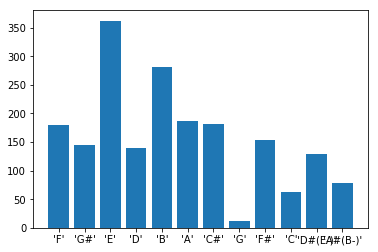

1


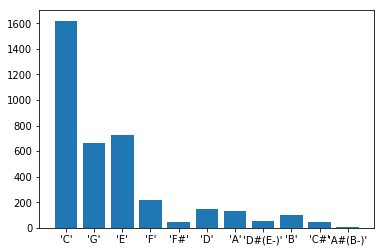

2


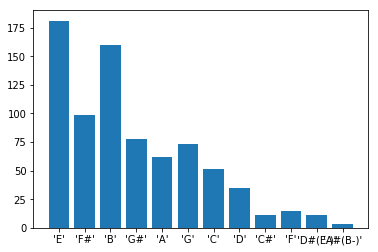

3


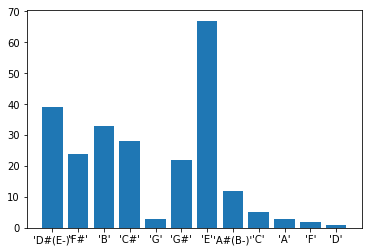

4


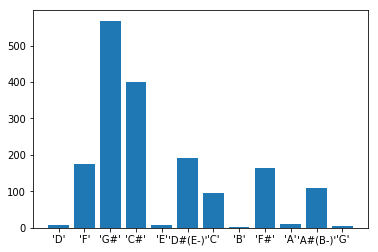

5


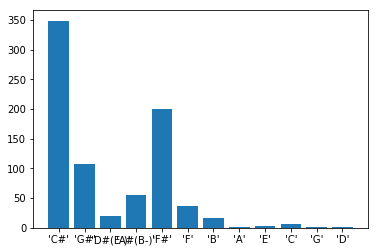

6


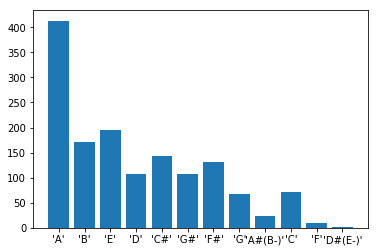

7


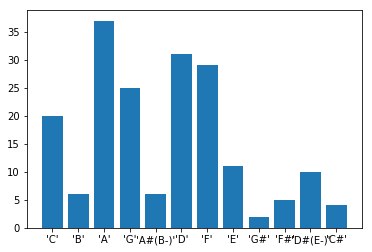

8


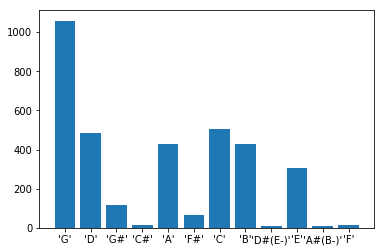

9


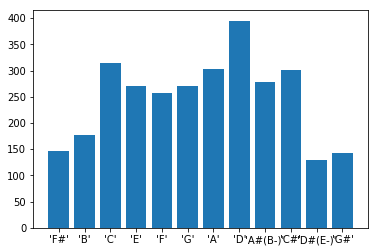

10


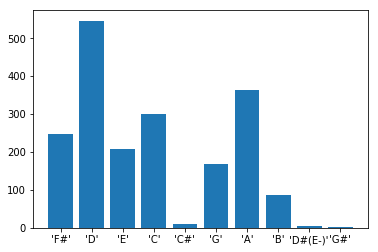

11


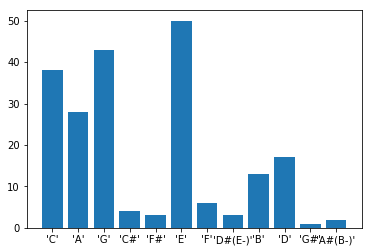

12


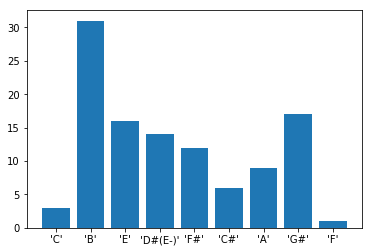

13


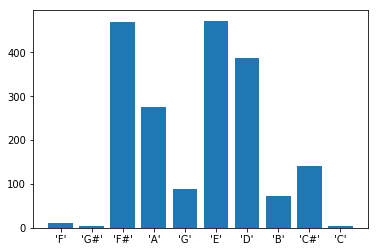

14


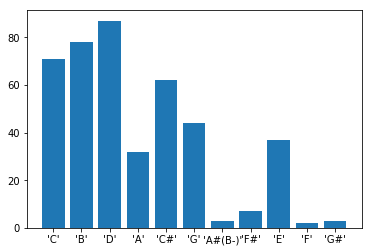

15


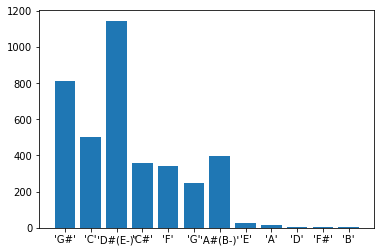

16


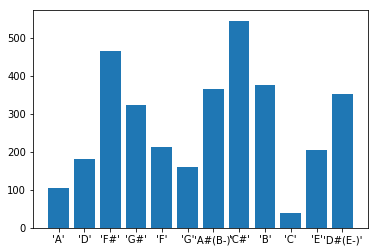

17


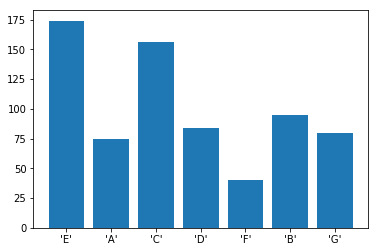

18


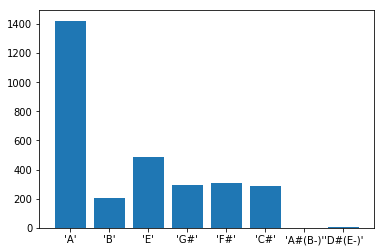

19


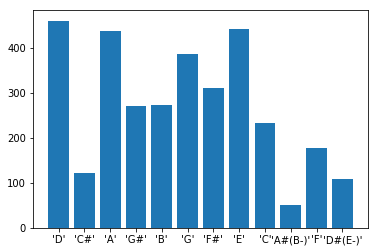

20


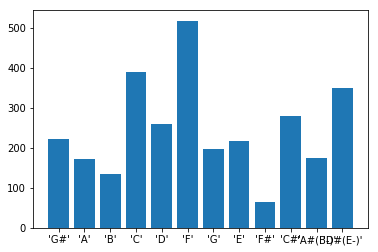

21


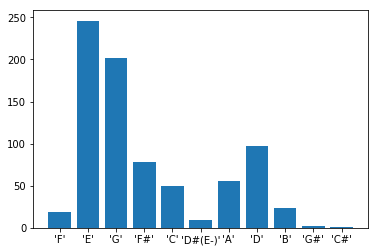

22


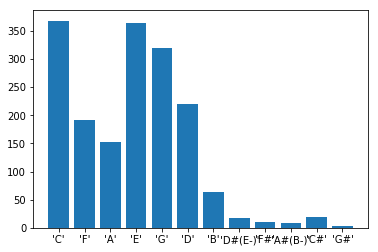

23


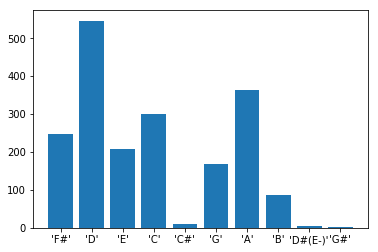

24


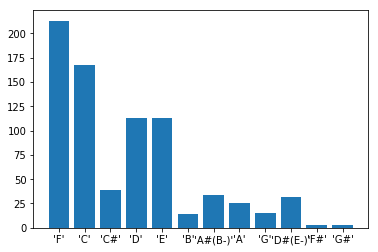

25


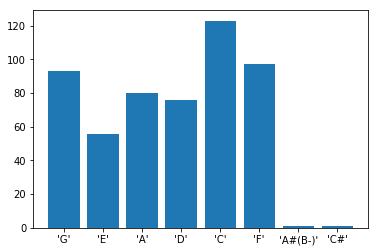

26


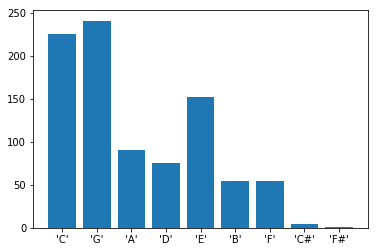

27


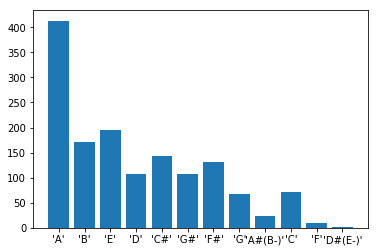

28


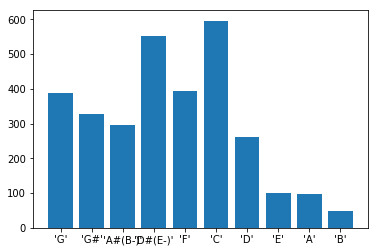

29


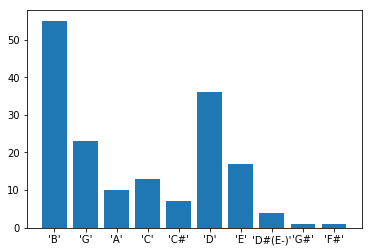

30


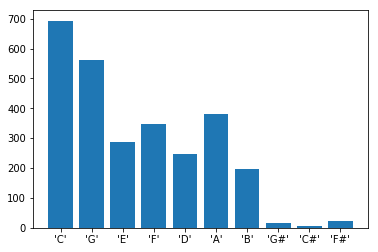

31


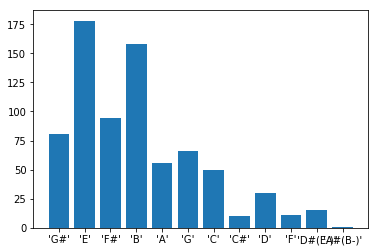

32


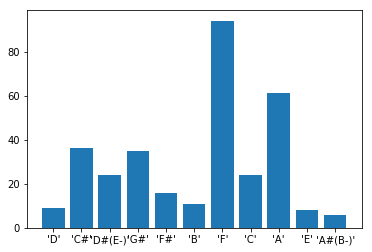

33


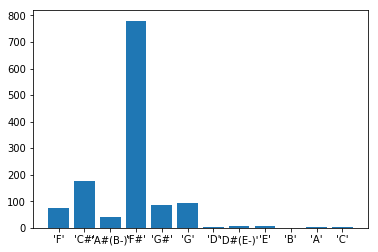

34


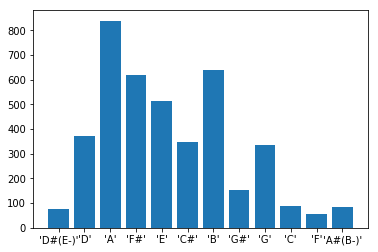

35


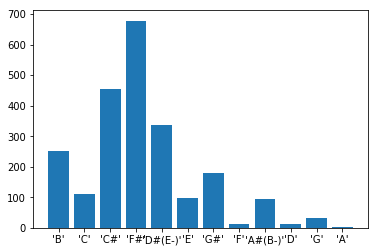

36


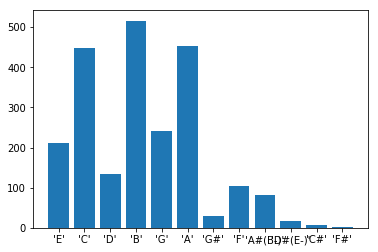

37


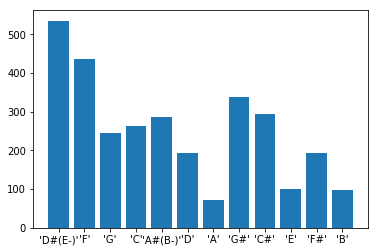

38


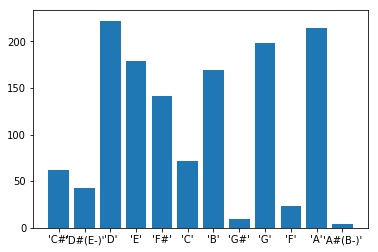

39


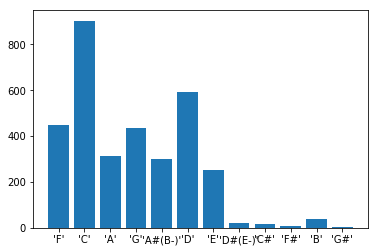

40


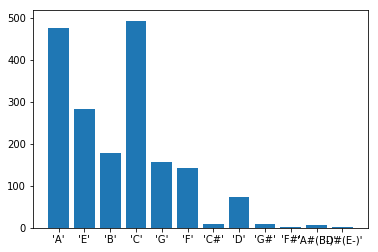

41


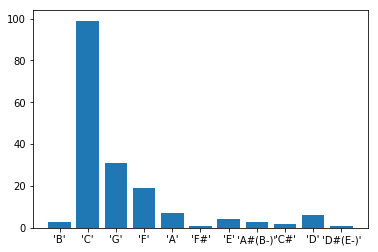

42


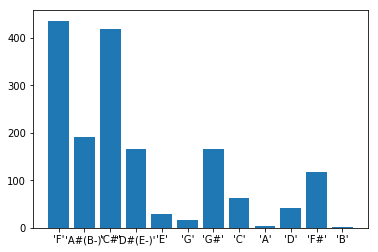

43


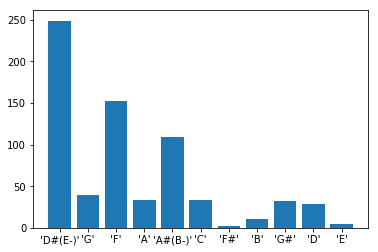

44


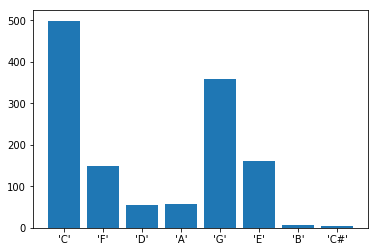

45


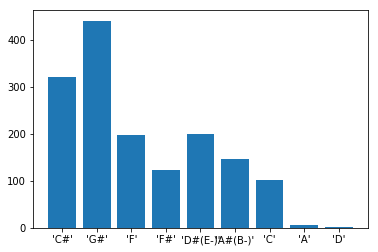

46


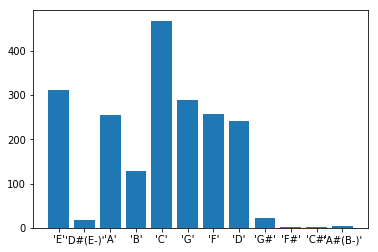

47


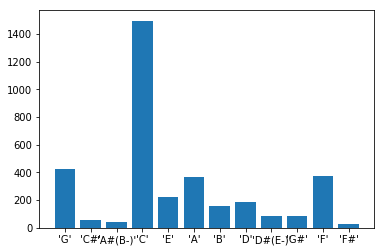

48


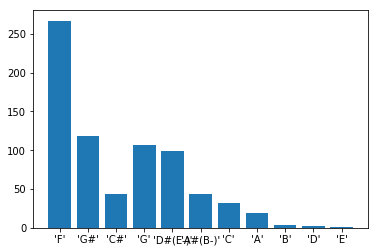

49


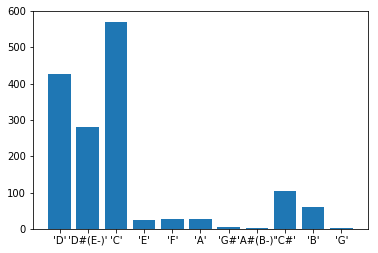

50


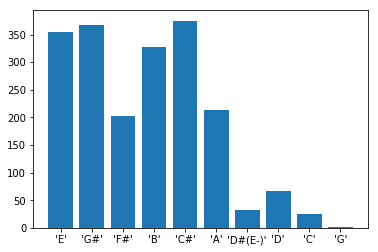

51


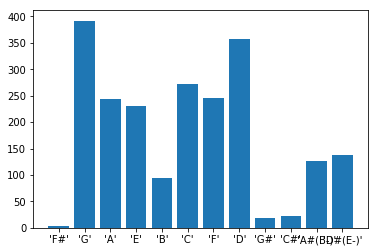

52


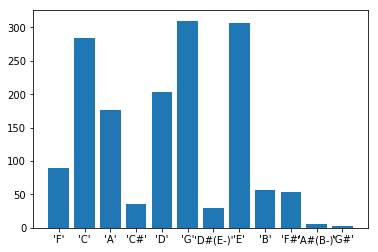

53


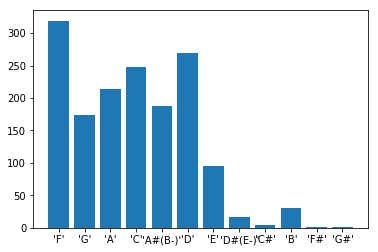

54


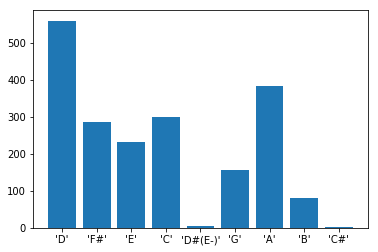

55


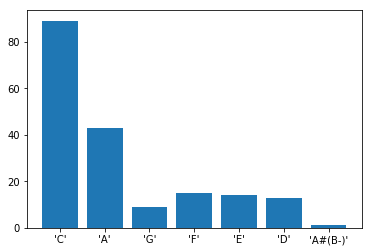

56


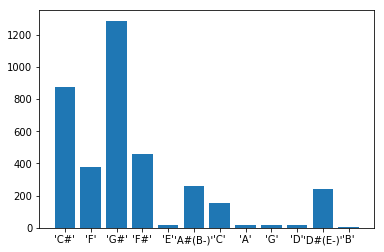

57


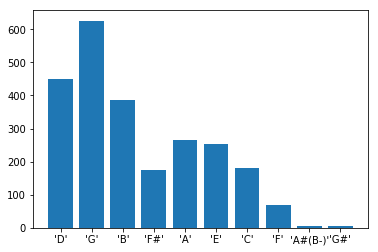

58


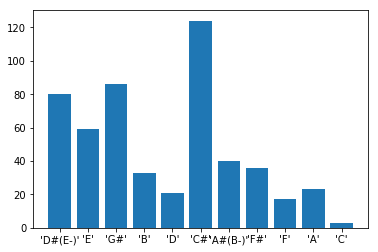

59


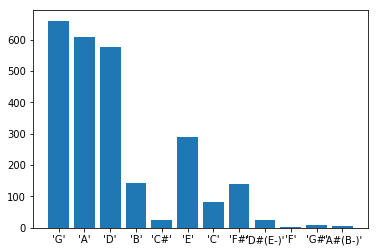

60


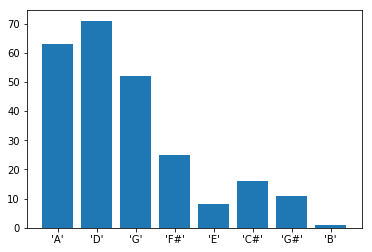

61


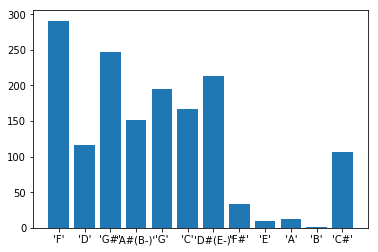

62


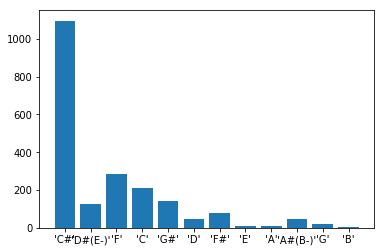

63


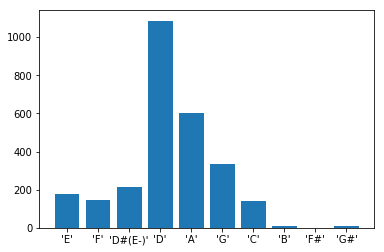

64


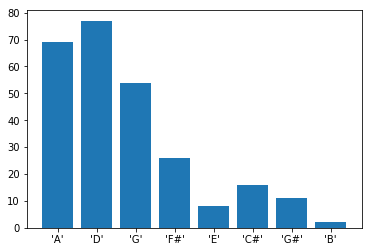

65


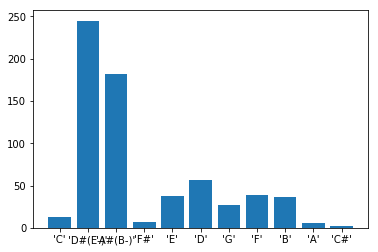

66


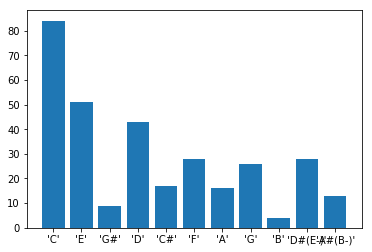

67


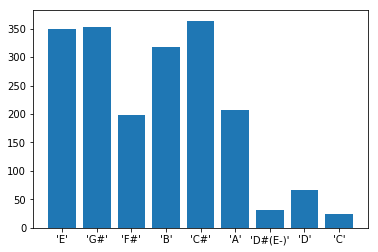

68


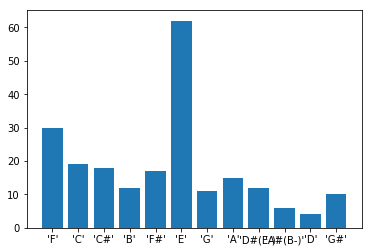

69


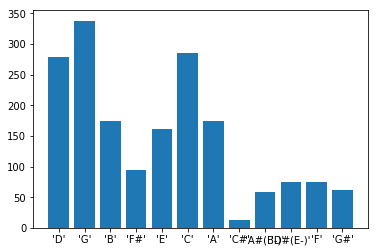

70


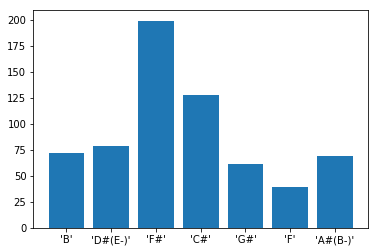

71


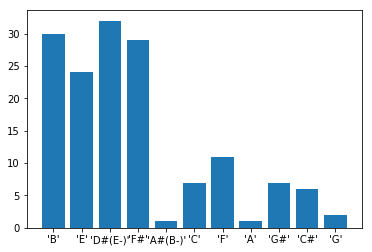

72


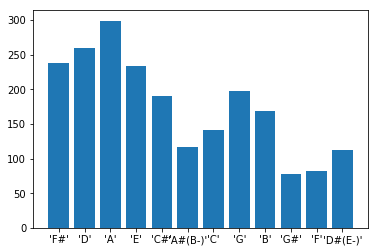

73


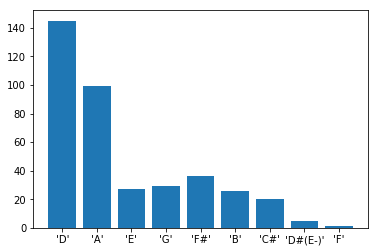

74


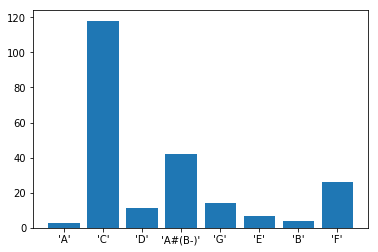

In [418]:
for idx in range(len(pitch)): 
    ngram_pitch = n_gram2(pitch[idx], 1)
    plt.bar(range(len(ngram_pitch)), list(ngram_pitch.values()), align='center')
    plt.xticks(range(len(ngram_pitch)), (ngram_pitch.keys()))
    print(idx)
    plt.show()

### Pitch progression in all dataset

In [423]:
## flatteren
flattened = [val for sublist in pitch for val in sublist]
perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(flattened, 1,0,2)
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')
print()

Perfect 5: 9.67 %
Big three: 5.28 %
Small 5.07 %
Stable: 35.08 %
Four: 9.78 %
WholeTone: 12.64 %
Other 22.5 %



### Pitch progression in each songs

In [424]:
for i in range(len(pitch)):
    perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(pitch[i], 1,0,2)
    print(i, sleeping_music[i])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Four:",four_, '%')
    print("WholeTone:",whole_, '%')
    print("Other",non_, '%')
    print()

0 1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav
Perfect 5: 10.41 %
Big three: 3.82 %
Small 4.71 %
Stable: 39.12 %
Four: 8.79 %
WholeTone: 11.45 %
Other 21.65 %

1 3小时放鬆的音樂  背景音樂  純音樂 輕快 水音  禪修音樂  輕音樂  心靈音樂.wav
Perfect 5: 9.42 %
Big three: 7.57 %
Small 3.37 %
Stable: 39.1 %
Four: 12.03 %
WholeTone: 6.58 %
Other 21.9 %

2 Relaxing Piano Music Sleep Music Water Sounds Relaxing Music Meditation Music ★47🍀.wav
Perfect 5: 10.23 %
Big three: 3.32 %
Small 7.29 %
Stable: 16.11 %
Four: 14.19 %
WholeTone: 19.05 %
Other 29.67 %

3 [無廣告版] 讀書工作好心情！放鬆舒壓鋼琴和大自然音律 - 5 HOURS RELAX STUDYING MUSIC FOR CONCENTRATION.wav
Perfect 5: 6.61 %
Big three: 5.79 %
Small 6.61 %
Stable: 30.58 %
Four: 7.44 %
WholeTone: 11.57 %
Other 30.99 %

4 m1.wav
Perfect 5: 12.25 %
Big three: 3.62 %
Small 1.61 %
Stable: 46.98 %
Four: 11.04 %
WholeTone: 7.48 %
Other 16.96 %

5 m10.wav
Perfect 5: 15.12 %
Big three: 3.38 %
Small 0.62 %
Stable: 52.88 %
Four: 14.75 %
WholeTone: 3.75 %
Other 9.38 %

6 m11.wav
Perfect 5: 10.52 %
Big thr

In [223]:
Counter(chord[3])

Counter({'C': 99, 'G': 109, 'D': 68, 'A': 19, 'F': 5})

## Visualize

In [425]:
def plot_wordcloud(data, max_word):
    wordcloud = WordCloud(max_words=max_word, max_font_size=1500,background_color='black',width=2000, height=2000,margin=2).\
    generate_from_frequencies(data)
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.imshow(wordcloud)

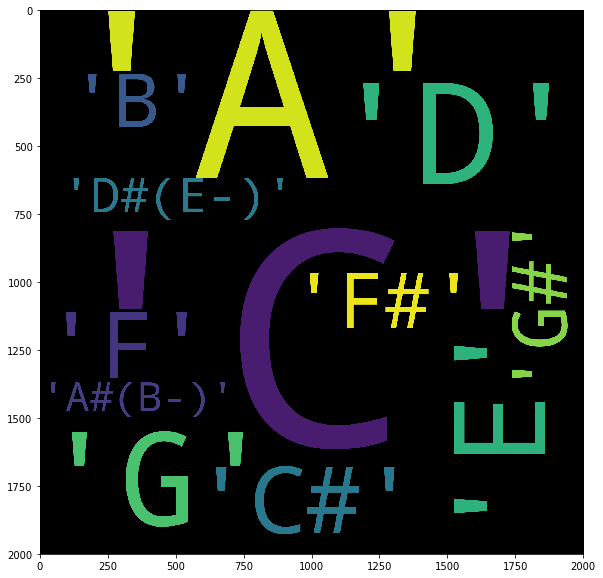

In [426]:
## pitch frequency
a = n_gram(pitch, 1)
plot_wordcloud(a,50)

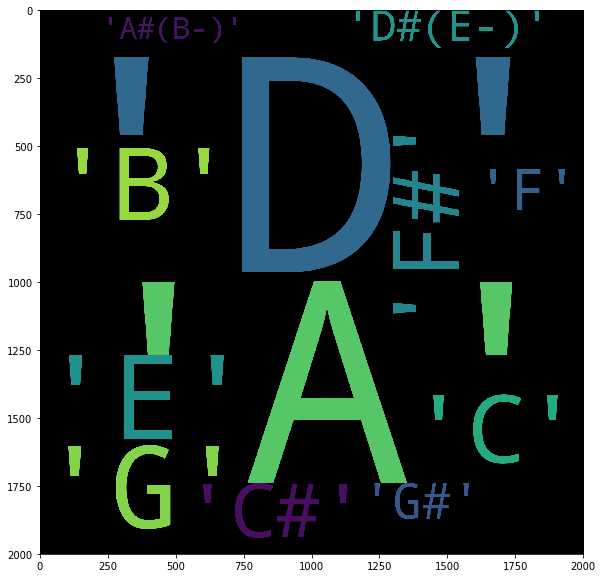

In [427]:
## chord frequency
a = n_gram(sleeping_key,1)
plot_wordcloud(a,50)

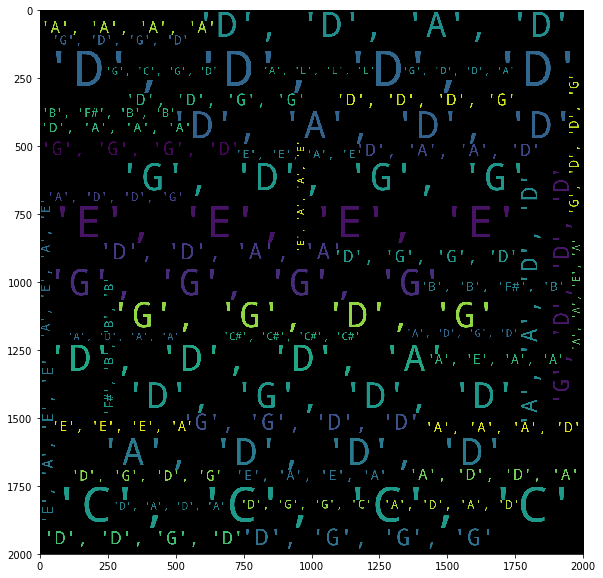

In [428]:
a = n_gram(sleeping_key,4)
plot_wordcloud(a,50)

### Unused code

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

In [129]:
# y, sr = librosa.load('./music/sleeping/m1.wav', duration=80)
# chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
# chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

In [130]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 5))
# librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('Chromagram')
# plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)


In [170]:
# def n_gram(key_list, ngram):
#     k_list = [[word for word in line.split(",")] for line in key_list]
#     flattened = [val for sublist in k_list for val in sublist]
#     ngram_key = []
#     for i in range(int(len(flattened)/ngram)):
#         ngram_key.append(flattened[ngram*i : ngram*(i+1)])
#     count_ary = [[x,ngram_key.count(x)] for x in (ngram_key)]
#     unique = []
#     for item in count_ary:
#         if item not in unique:
#             unique.append(item)
#     unique = sorted(unique, key=lambda x:x[1], reverse = True)
#     return unique